In [1]:
%matplotlib inline

# Top level imports
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Location for training and validation images.
PATH = 'Images/data/'
os.listdir(PATH)

['.DS_Store', 'cifar-10-batches-py', 'train', 'cifar-10-python.tar.gz', 'val']

In [3]:
# Pytorch imports
import torch
import torchvision
import torchvision.transforms as transforms

import torchvision.models as mdl
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets

In [4]:
# Location for the training and validation sets
traindir = os.path.join(PATH, 'train')
valdir = os.path.join(PATH, 'val')

scale = 224

# Transforms the images into a nice format.
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
resize = transforms.Resize(scale)
resizecrop = transforms.RandomResizedCrop(scale)

# Transformation object, converts to a tensor then normalizes.
trans = transforms.Compose([resize, transforms.ToTensor(), normalize])

# Image folders
trainfolder = datasets.ImageFolder(traindir, transform=trans)
valfolder = datasets.ImageFolder(valdir, transform=trans)

# Loader objects for loading the data, batches of 5.
trainloader = torch.utils.data.DataLoader(trainfolder, batch_size=5, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valfolder, batch_size=5, shuffle=False, num_workers=2)



The following cell contains an implementation of the cyclical learning rate policy, as originally outlined by Leslie Smith in https://arxiv.org/abs/1506.01186. I did not write this code. I found it from the following pull request currently under review for inclusion in PyTorch: https://github.com/pytorch/pytorch/pull/2016. The code itself can originally be found here: https://github.com/thomasjpfan/pytorch/blob/401ec389db2c9d2978917a6e4d1101b20340d7e7/torch/optim/lr_scheduler.py. Should it get pulled into PyTorch porper I will remove this.

In [5]:
from torch.optim import Optimizer
class CyclicLR(object):
    """Sets the learning rate of each parameter group according to
    cyclical learning rate policy (CLR). The policy cycles the learning
    rate between two boundaries with a constant frequency, as detailed in
    the paper `Cyclical Learning Rates for Training Neural Networks`_.
    The distance between the two boundaries can be scaled on a per-iteration
    or per-cycle basis.
    Cyclical learning rate policy changes the learning rate after every batch.
    `batch_step` should be called after a batch has been used for training.
    To resume training, save `last_batch_iteration` and use it to instantiate `CycleLR`.
    This class has three built-in policies, as put forth in the paper:
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each
        cycle iteration.
    This implementation was adapted from the github repo: `bckenstler/CLR`_
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        base_lr (float or list): Initial learning rate which is the
            lower boundary in the cycle for eachparam groups.
            Default: 0.001
        max_lr (float or list): Upper boundaries in the cycle for
            each parameter group. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore
            max_lr may not actually be reached depending on
            scaling function. Default: 0.006
        step_size (int): Number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch. Default: 2000
        mode (str): One of {triangular, triangular2, exp_range}.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
            Default: 'triangular'
        gamma (float): Constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
            Default: 1.0
        scale_fn (function): Custom scaling policy defined by a single
            argument lambda function, where
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored
            Default: None
        scale_mode (str): {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on
            cycle number or cycle iterations (training
            iterations since start of cycle).
            Default: 'cycle'
        last_batch_iteration (int): The index of the last batch. Default: -1
    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> scheduler = torch.optim.CyclicLR(optimizer)
        >>> data_loader = torch.utils.data.DataLoader(...)
        >>> for epoch in range(10):
        >>>     for batch in data_loader:
        >>>         scheduler.batch_step()
        >>>         train_batch(...)
    .. _Cyclical Learning Rates for Training Neural Networks: https://arxiv.org/abs/1506.01186
    .. _bckenstler/CLR: https://github.com/bckenstler/CLR
    """

    def __init__(self, optimizer, base_lr=1e-3, max_lr=6e-3,
                 step_size=2000, mode='triangular', gamma=1.,
                 scale_fn=None, scale_mode='cycle', last_batch_iteration=-1):

        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer

        if isinstance(base_lr, list) or isinstance(base_lr, tuple):
            if len(base_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} base_lr, got {}".format(
                    len(optimizer.param_groups), len(base_lr)))
            self.base_lrs = list(base_lr)
        else:
            self.base_lrs = [base_lr] * len(optimizer.param_groups)

        if isinstance(max_lr, list) or isinstance(max_lr, tuple):
            if len(max_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} max_lr, got {}".format(
                    len(optimizer.param_groups), len(max_lr)))
            self.max_lrs = list(max_lr)
        else:
            self.max_lrs = [max_lr] * len(optimizer.param_groups)

        self.step_size = step_size

        if mode not in ['triangular', 'triangular2', 'exp_range'] \
                and scale_fn is None:
            raise ValueError('mode is invalid and scale_fn is None')

        self.mode = mode
        self.gamma = gamma

        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = self._triangular_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = self._triangular2_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = self._exp_range_scale_fn
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode

        self.batch_step(last_batch_iteration + 1)
        self.last_batch_iteration = last_batch_iteration

    def batch_step(self, batch_iteration=None):
        if batch_iteration is None:
            batch_iteration = self.last_batch_iteration + 1
        self.last_batch_iteration = batch_iteration
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

    def _triangular_scale_fn(self, x):
        return 1.

    def _triangular2_scale_fn(self, x):
        return 1 / (2. ** (x - 1))

    def _exp_range_scale_fn(self, x):
        return self.gamma**(x)

    def get_lr(self):
        step_size = float(self.step_size)
        cycle = np.floor(1 + self.last_batch_iteration / (2 * step_size))
        x = np.abs(self.last_batch_iteration / step_size - 2 * cycle + 1)

        lrs = []
        param_lrs = zip(self.optimizer.param_groups, self.base_lrs, self.max_lrs)
        for param_group, base_lr, max_lr in param_lrs:
            base_height = (max_lr - base_lr) * np.maximum(0, (1 - x))
            if self.scale_mode == 'cycle':
                lr = base_lr + base_height * self.scale_fn(cycle)
            else:
                lr = base_lr + base_height * self.scale_fn(self.last_batch_iteration)
            lrs.append(lr)
        return lrs

In [6]:
lrs = []
def train(loader, net, crit, opt, lr):
    net.train()
    
    #sched = CyclicLR(opt, mode='triangular', base_lr=lr, max_lr=lr*5, step_size=400, gamma=1.1)
    
    running_loss = 0.0
    for i, batch in enumerate(loader, 0):
        
        #sched.batch_step()
        
        # Get the input with their true labels
        inputs, labels = batch
        
        for param_group in opt.param_groups:
            lrs.append(param_group['lr'])

        # Zeros the optimzer
        opt.zero_grad()

        # Get the predicted labels and find the loss by comparing
        outputs = net(inputs)
        loss = crit(outputs, labels)
        
        # Propagate the loss backwards
        loss.backward()
        opt.step()

        # Prints every 5 batches (Batch size currently 5, so every 25 images)
        running_loss += loss.item()
        if i % 5 == 4:
            print('[%d, %5d] Avg. loss: %.3f' % (epoch + 1, i + 1, running_loss / 5))
            running_loss = 0.0
    
    

In [7]:
global_lr = 0.01
# Sets up the network
net = mdl.resnet34(True) # True = pretrained on ImageNet

# This first makes it accept images of any size (resnet34 was designed for 224x224)
#net.avgpool = nn.AdaptiveAvgPool2d(1)

# Sets it up so that there are two output classes.
net.fc = torch.nn.Linear(512,2)

# Sets up required network functions
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=global_lr, momentum=0.9)


In [8]:
for epoch in range(2):
    train(trainloader, net, criterion, optimizer, lr=global_lr)

print('Finished Training')
print(lrs)

[1,     5] Avg. loss: 0.570
[1,    10] Avg. loss: 1.062
[1,    15] Avg. loss: 0.931
[1,    20] Avg. loss: 2.416
[1,    25] Avg. loss: 3.201
[1,    30] Avg. loss: 2.661
[1,    35] Avg. loss: 0.615
[1,    40] Avg. loss: 0.548
[1,    45] Avg. loss: 2.785
[2,     5] Avg. loss: 0.524
[2,    10] Avg. loss: 3.361
[2,    15] Avg. loss: 2.020
[2,    20] Avg. loss: 0.809
[2,    25] Avg. loss: 0.655
[2,    30] Avg. loss: 3.848
[2,    35] Avg. loss: 1.587
[2,    40] Avg. loss: 1.398
[2,    45] Avg. loss: 1.381
Finished Training
[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0

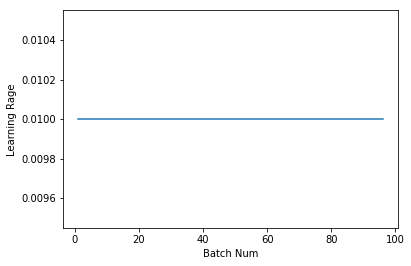

In [9]:
x = np.asarray(range(len(lrs))) + 1
plt.plot(x, lrs)
plt.xlabel('Batch Num')
plt.ylabel('Learning Rage')
plt.show()

In [10]:
def unnormalize(img):
    # Transform does x_new = (x - mean)/sigma
    # Reverse the math x = (x_new + mean/sigma)/(1/sigma)
    # So mean_new = -mean/sigma
    # sigma_new = 1/sigma
    inv = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],std=[1/0.229, 1/0.224, 1/0.225])
    
    return inv(img)
    

The following cells are for validation.

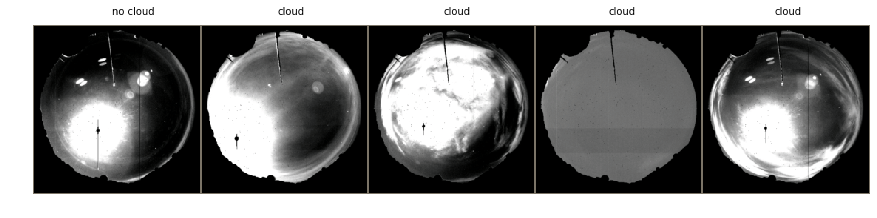

In [11]:
images, labels = iter(trainloader).next()
img = torchvision.utils.make_grid(images)

# Unnormalize and convert to a numpy array for display
img = unnormalize(img)
img = img.numpy()

# Transpose the array to (dim1, dim2, dim0)
img2 = np.transpose(img, (1, 2, 0))

# Display, make it bigger, turn off the axes
fig, ax = plt.subplots()
ax.set_axis_off()
fig.set_size_inches(15, 7)
plt.imshow(img2)

classes = ['cloud', 'no cloud']

for j in range(5):
    label = classes[labels[j]]
    x = ((scale - 12) / 2) + (j * scale)
    ax.text(x, -15, label)

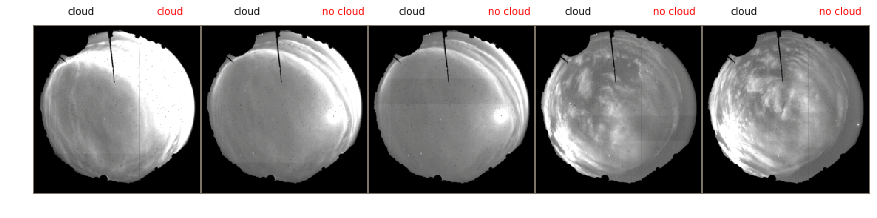

In [12]:
images, labels = iter(valloader).next()

# Display the images, with their true labels
img = torchvision.utils.make_grid(images)

# Unnormalize and convert to a numpy array for display
img = unnormalize(img)
img = img.numpy()

# Transpose the array to (dim1, dim2, dim0)
img2 = np.transpose(img, (1, 2, 0))

# Display, make it bigger, turn off the axes
fig, ax = plt.subplots()
ax.set_axis_off()
fig.set_size_inches(15, 7)
plt.imshow(img2)

# Gap between true and predicted labels
gap = 120

for j in range(5):
    label = classes[labels[j]]
    x = ((scale - 12) / 2) + (j * scale) - (gap / 2)
    ax.text(x, -15, label)

#net.eval()

# Get the network's predicted labels
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# Puts the predicted labels in red next to the true labels
for j in range(5):
    label = classes[predicted[j]]
    x = ((scale - 12) / 2) + (j * scale) + (gap / 2)
    ax.text(x, -15, label, color='r')

In [13]:
preds = np.asarray([])
trues = np.asarray([])

correct = 0
total = 0
with torch.no_grad():
    for data in valloader:
        # The true labels and image data
        images, labels = data
        
        # Gets the predicted labels
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Adds to the total the number of labels here (should be equal to batch size)
        total = total + labels.size(0)
        
        # If the predicted label is the same as the true label increment correct by 1
        correct += (predicted == labels).sum().item()
        
        trues = np.concatenate((trues, labels.numpy()))
        preds = np.concatenate((preds, predicted.numpy()))

accuracy = correct / total * 100
print('Total images: ' + str(total))
print('Accuracy: '  + str(accuracy) + '%')

Total images: 80
Accuracy: 52.5%


In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Text(33.0, 0.5, 'Predicted')

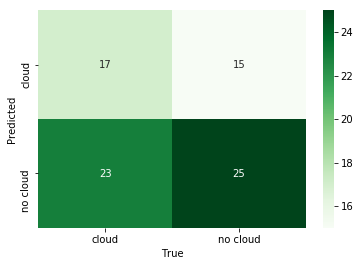

In [16]:
confusion = confusion_matrix(trues, preds)

sns.heatmap(confusion.T, annot=True, cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.xlabel('True')
plt.ylabel('Predicted')